In [4]:
import os  
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [9]:
import pathlib

In [29]:
import PIL
import PIL.Image

In [39]:
import numpy as np

In [5]:
model = tf.keras.applications.MobileNet()

2022-06-09 19:34:49.289365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 19:34:49.289901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
17225924/17225924 [==============================] - 3s 0us/step


In [12]:
data_dir = pathlib.Path('dataset')

In [28]:
NG_image_count = len(list(data_dir.glob('NG/*.jpg')))
OK_image_count = len(list(data_dir.glob('OK/*.jpg')))
print("NG_image_count:",NG_image_count)
print("OK_image_count",OK_image_count)

NG_image_count: 10
OK_image_count 90


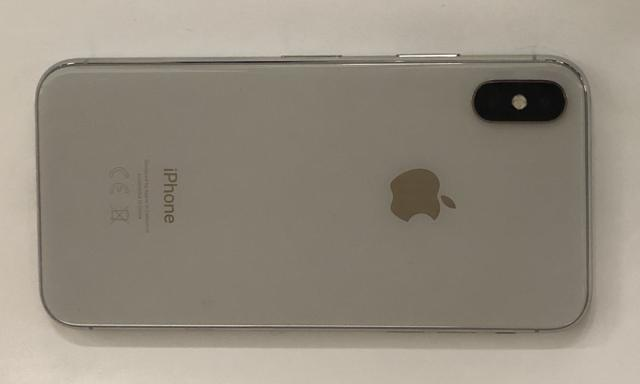

In [30]:
okimages = list(data_dir.glob('OK/*'))
PIL.Image.open(str(okimages[0]))

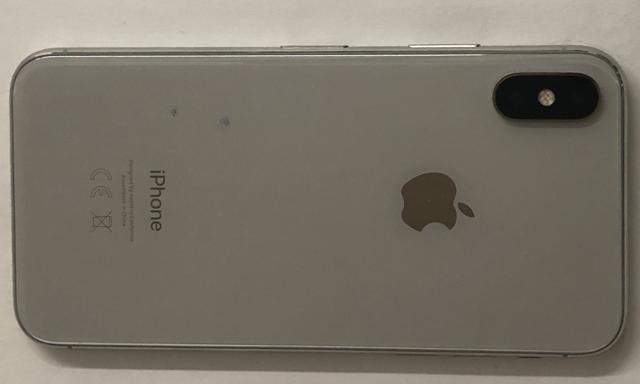

In [31]:
badimages = list(data_dir.glob('NG/*'))
PIL.Image.open(str(badimages[0]))

In [44]:
batch_size = 5
img_height = 224
img_width = 224
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 80 files for training.


In [45]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 20 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['NG', 'OK']


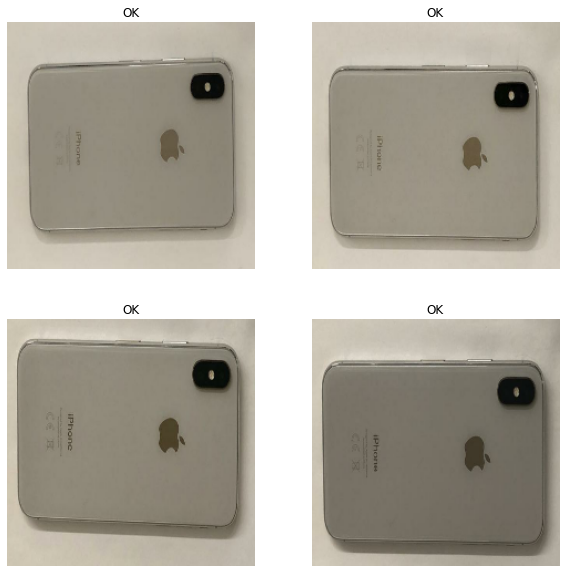

In [47]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [48]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.017147481 0.9787122


In [49]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/Users/yiranxu/miniforge3/envs/tf26/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-06-09 20:39:33.124956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 2.2129 - accuracy: 0.6625

2022-06-09 20:39:40.865308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 9s 108ms/step - loss: 2.2129 - accuracy: 0.6625 - val_loss: 0.7076 - val_accuracy: 0.9500
Epoch 2/10
16/16 [==============================] - 1s 78ms/step - loss: 0.3718 - accuracy: 0.9000 - val_loss: 3.7726 - val_accuracy: 0.0500
Epoch 3/10
16/16 [==============================] - 1s 82ms/step - loss: 0.4009 - accuracy: 0.9250 - val_loss: 0.2902 - val_accuracy: 0.9500
Epoch 4/10
16/16 [==============================] - 1s 81ms/step - loss: 0.0935 - accuracy: 0.9500 - val_loss: 0.4980 - val_accuracy: 0.9500
Epoch 5/10
16/16 [==============================] - 1s 80ms/step - loss: 0.0729 - accuracy: 0.9625 - val_loss: 0.8800 - val_accuracy: 0.9500
Epoch 6/10
16/16 [==============================] - 1s 80ms/step - loss: 0.1093 - accuracy: 0.9875 - val_loss: 0.5317 - val_accuracy: 0.9500
Epoch 7/10
16/16 [==============================] - 1s 78ms/step - loss: 0.1260 - accuracy: 0.9500 - val_loss: 0.2266 - val_accuracy: 0.8500
Epoch 8/10
16/16 [=====